#**[Pedro] Analytics Engineer Take Home Assignment**

#Dataset

The dataset for this exercise was taken from the publicly available StackOverflow BigQuery dataset. StackOverflow is a question and answer website where programmers ask/answer questions and share knowledge. Users can post questions, answer posted questions, comment on questions or answers, and up/downvote questions/answers/comments.


#Question 1
How has the rate of users asking questions changed over the past few months?

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
project_id = 'stackoverflow-test-toggl'

from google.cloud import bigquery
import pandas as pd

client = bigquery.Client(project=project_id)

df1 = client.query('''
  --How has the rate of users asking questions changed over the past few months?

select count(distinct(owner_user_id)) as Users_Making_Questions, date_trunc(creation_date, month) as Creation_month, --DATE_TRUNC(CAST('2021-01-01' AS DATE), MONTH) AS month,
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2019-01-01' and creation_date < '2022-03-01'
group by 2
order by 2 desc
''').to_dataframe()

df1.head()
m = df1['Users_Making_Questions'].mean()
c = len(df1.index)

print('the average number of users asking questions in the last ' + str(c) +' months was ' + str(m) +' users/month')

the average number of users asking questions in the last 38 months was 104940.21052631579 users/month


Text(0.5, 1.0, 'Users asking questions per month')

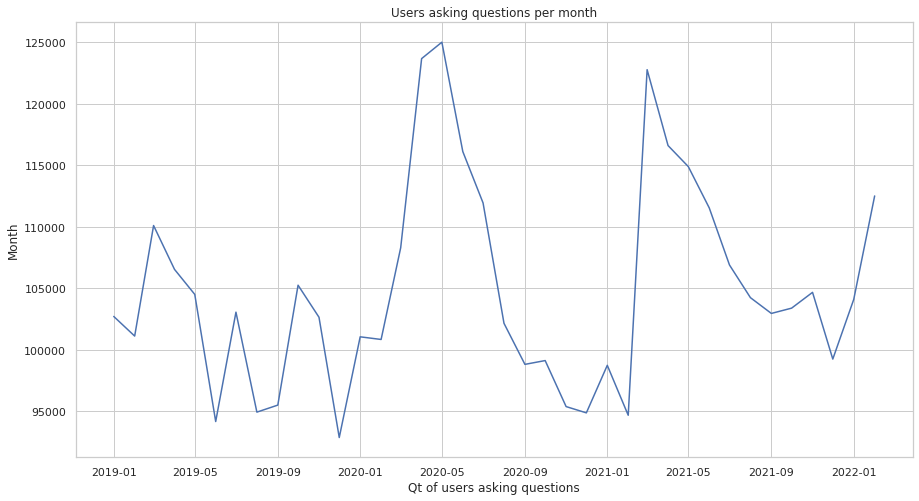

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "Creation_month", y = "Users_Making_Questions", data=df1)
plt.xlabel("Qt of users asking questions")
plt.ylabel("Month")
plt.title("Users asking questions per month")

# Question 2
How has the participation rate (questions, answers, comments) of users changed in the last 3 months, compared with the period before?

I separated the amount of users who created questions, answers or comments in the current quarter (Q0) and compared it to the previous quarter (Q-1).

In [ ]:
df2 = client.query('''

-- I intended to use the DATE_ADD function to group the quarters more efficiently, but the function did not behave the way I expected in Bigquery,
-- so because it was only comparing two periods I used UNION ALL.
-- But I do not consider this the best practice
-- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous quarter

WITH Quarters as
(select count(distinct(owner_user_id)) as Participation, 'questions' as Item, 'Q0' as Quarter
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date between DATE_ADD(creation_date, INTERVAL -180 DAY) and DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'answers' as Item, 'Q0' as Quarter
FROM
  `bigquery-public-data.stackoverflow.posts_answers`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

Select count(distinct(user_id)) as Participation, 'comments' as Item, 'Q0' as Quarter
FROM
  `bigquery-public-data.stackoverflow.comments`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'questions' as Item, 'Q-1' as Quarter
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'answers' as Item, 'Q-1' as Quarter
FROM
  `bigquery-public-data.stackoverflow.posts_answers`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

Select count(distinct(user_id)) as Participation, 'comments' as Item, 'Q-1' as Quarter
FROM
  `bigquery-public-data.stackoverflow.comments`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

)

SELECT * FROM Quarters
''').to_dataframe()

print(df2)

   Participation       Item Quarter
0         270016    answers     Q-1
1         151352    answers      Q0
2         476178  questions     Q-1
3         238719   comments      Q0
4         265820  questions      Q0
5         406681   comments     Q-1


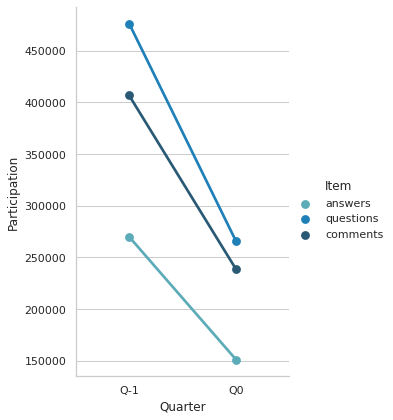

In [ ]:
sns.set_theme(style="whitegrid")
sns.catplot(data=df2, x = 'Quarter', y = 'Participation', hue = 'Item', capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75)


# Question 3
How does the reputation growth rate of users who answer questions frequently compare with those who do so less frequently?

For this solution I separated in a table the reputation and responses per user and identified the growth rate using a simple linear regression model.

The angular coefficient of the model was significant and corresponds to the growth rate.

In [ ]:
df3 = client.query('''
select a.display_name Name, a.reputation Reputation, b.answers Answers
FROM
  `bigquery-public-data.stackoverflow.users` as a
JOIN (select count(id) as answers, owner_user_id
from
  `bigquery-public-data.stackoverflow.posts_answers`
  group by 2) as b ON a.id = b.owner_user_id
where creation_date > '2019-01-01'
''').to_dataframe()

df3.head()

,Name,Reputation,Answers
0,red_menace,2702,164
1,Halil Ural,14,2
2,Vladimir Rodichev,353,26
3,Vishwajeet Singh,131,1
4,deonardo_licaprio,154,5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


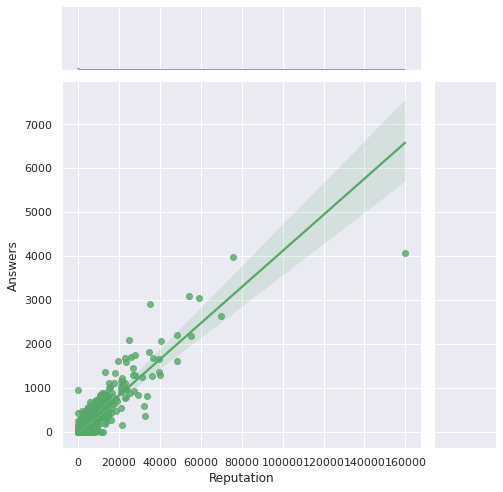

In [ ]:
sns.set(style = "darkgrid")
tips = sns.load_dataset("tips")
color = sns.color_palette()[2]
sns.jointplot("Reputation", 
                  "Answers", 
                  data = df3, 
                  kind = "reg", 
                  color = color, 
                  size = 7)

In [ ]:
import statsmodels as st
import statsmodels.formula.api as sm
import pandas as pd

modeldf = pd.DataFrame(df3)
result = sm.ols(formula="Reputation ~ Answers", data=df3).fit()
print(result.params)
print(result.summary())

Intercept    -6.937978
Answers      19.916064
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             Reputation   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 2.162e+06
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:39:54   Log-Likelihood:            -3.2494e+06
No. Observations:              478294   AIC:                         6.499e+06
Df Residuals:                  478292   BIC:                         6.499e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

The result of the adjustment shows that **the average growth rate of Reputation is 1 point for every 19.91 answers given by the user**.

The adjustment coefficient R² of 0.819 indicates a good quality fit, the p-value of t for the responses indicates the significance of the variable on Reputation (that the impact is not zero).

The rest of the information is just details for model validation, important if further investigation is initiated.

# Question 4
In terms of quality of answers (as measured by the number of favorites and comments received), which monthly cohorts of registered users produced the best answers?

We have two three ways to analyze this question. The first is by considering the average number of bookmarks received per response per user, the second only the number of comments received per response per user and the third is by using a weighted average of bookmarks and comments per response per user.

It is important to use the average as a measure of quality because if we use only absolute values, a user who made few replies but always with good ratings could be considered of less quality than a user who receives few comments and bookmarks in his replies but publishes many replies.

Example: User1: 230 comments in 23 replies, User2: 300 comments in 400 replies.
Which user produced the best quality comments? I believe it is User1

The cohort concept used is the month of registration: https://en.wikipedia.org/wiki/Cohort_(statistics)

Info: the favorites column is empty in the post_answers table, so it is not included in the final analysis

In [ ]:
df4 = client.query('''

SELECT AVG(Comments) as Quality_rate, date_trunc(creation_date, month) as user_creation_month
from
(
select
AVG(cast(a.favorite_count as NUMERIC)) as Favorites, -- in this subquery we notice that the column favorite_count is empty in the "post_answers" table, so it is not inserted in the final quality indicator
AVG(a.comment_count) as Comments,
a.owner_user_id as owner_user_id,
b.creation_date as creation_date
from
 `bigquery-public-data.stackoverflow.posts_answers` as a
join
 `bigquery-public-data.stackoverflow.users` as b
on a.owner_user_id = b.id
where b.creation_date > '2019-01-01'
GROUP BY 3, 4
)
GROUP BY 2
ORDER BY 2 ASC

''').to_dataframe()

df4.head()

,Quality_rate,user_creation_month
0,0.527468,2019-01-01 00:00:00+00:00
1,0.513515,2019-02-01 00:00:00+00:00
2,0.518887,2019-03-01 00:00:00+00:00
3,0.508108,2019-04-01 00:00:00+00:00
4,0.484962,2019-05-01 00:00:00+00:00


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

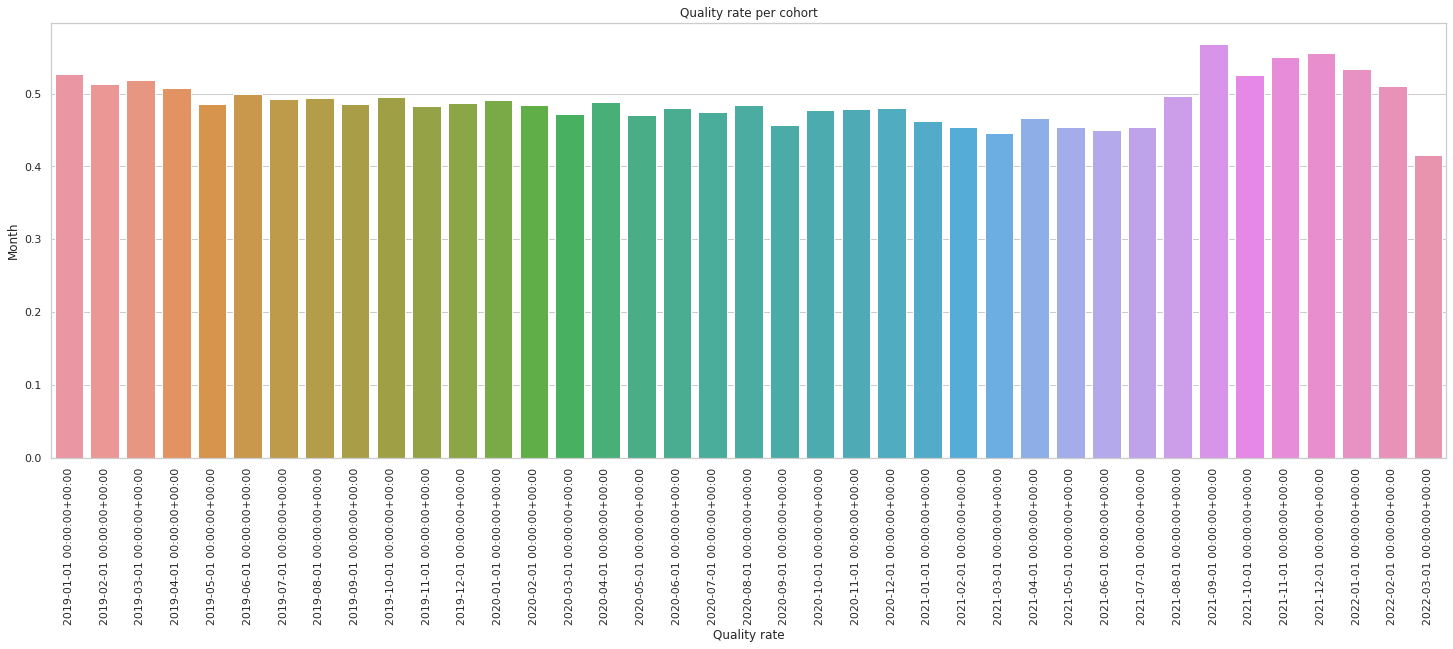

In [ ]:
df4 = df4.sort_values(['user_creation_month'])
sns.set_theme(style="whitegrid")
plt.figure(figsize=(25,8))
sns.barplot(x = "user_creation_month", y = "Quality_rate", data=df4)
plt.xlabel("Quality rate")
plt.ylabel("Month")
plt.title("Quality rate per cohort")
plt.xticks(rotation=90)

In [ ]:
df4 = df4.sort_values(['Quality_rate'], ascending=False)
df4.head()

,Quality_rate,user_creation_month
32,0.568316,2021-09-01 00:00:00+00:00
35,0.556232,2021-12-01 00:00:00+00:00
34,0.550319,2021-11-01 00:00:00+00:00
36,0.533711,2022-01-01 00:00:00+00:00
0,0.527468,2019-01-01 00:00:00+00:00


In [ ]:
max_qualityrate_month = df4.loc[1, 'user_creation_month']
max_qualityrate_month = max_qualityrate_month.strftime('%m/%Y')

print('The (monthly) cohort with the best user quality rate was ' + str(max_qualityrate_month))

The (monthly) cohort with the best user quality rate was 02/2019


# Question 5
What category (tag) of questions are driving the most engagement (questions, answers, comments, favorites), and how has this changed over time?

In this query we consider engagement as the sum of questions, answers, comments, and favorites in a given category (tag)

There are two subqueries that generate the final table.
The first one seeks to generate the split tags and truncate the creation dates by month.
The second raises the total of questions, comments, replies, favorites, and total engagement (sum).

The final table generates a table with the engagement history of the 10 most used tags.

In [ ]:

df5 = client.query('''

with tags as (
  -- table with all engagement vars
  SELECT tag, COUNT(*) total_questions, datas, sum(comment) comment, sum(answer) answer, sum(favorite) favorite, sum(comment + answer + favorite)+count(*) engagement
FROM (
  -- spliting tags
  SELECT SPLIT(tags, '|') tags, date_trunc(creation_date, month) as datas, comment_count comment, answer_count answer, favorite_count favorite
  FROM `bigquery-public-data.stackoverflow.posts_questions` a
  WHERE EXTRACT(YEAR FROM creation_date)>=2019
), UNNEST(tags) tag
GROUP BY 1, 3
ORDER BY 2 DESC), toptags as (select tag, sum(total_questions) total from tags group by tag order by 2 desc limit 10)

--Generates a table with the engagement history of the 10 most used tags (for this the inner join was performed)
SELECT t.* FROM tags t
INNER JOIN toptags tt
on t.tag = tt.tag
where datas < '2022-03-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
order by tag asc

''').to_dataframe()

df5.head()

,tag,total_questions,datas,comment,answer,favorite,engagement
0,android,5475,2021-09-01 00:00:00+00:00,8670,4212,499,7505
1,android,6552,2021-05-01 00:00:00+00:00,9454,4990,767,9271
2,android,7212,2019-04-01 00:00:00+00:00,14290,8711,1734,13764
3,android,5563,2022-02-01 00:00:00+00:00,7454,3149,256,6503
4,android,5655,2020-08-01 00:00:00+00:00,9917,5924,888,8846


Text(0.5, 1.0, 'Categories (tags) with highest engagement')

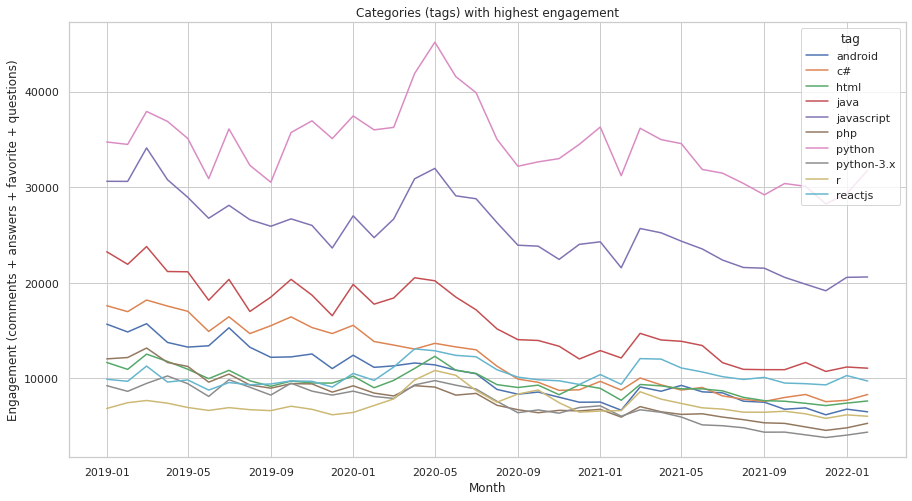

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "datas", y = "engagement", hue = 'tag', data=df5)
plt.xlabel("Month")
plt.ylabel("Engagement (comments + answers + favorite + questions)")
plt.title("Categories (tags) with highest engagement")

The graph above shows the fluctuation of engagement over time for the 10 most popular categories (tags).

# Question 6
Is the problem of unhelpful users (define this yourself) getting better or worse?

Unhelpful users definition: Users who post replies but have a negative average score.

A user who never posts doesn't help, but also doesn't hinder, but users who post and their questions have a negative score generate a more negative impact on the community or for the solution of the question itself.

Since those who follow the answer of an unhelpful user tend to waste time with an incorrect solution.

The unhelpful user is cargorized by period (in this case month) because he can change his attitude over time.

After generating the table with each of them, the behavior over time is analyzed.


In [ ]:
df6 = client.query('''

with unhelpful as (
  -- table with the average score calculation and selection of users with negative average score in the period
select owner_user_id, AVG(score) as Score, count(id) as Answers_posted, creation_month
FROM
  (
    -- table that selects the question, the user, score and truncates the date
    select owner_user_id, score, id, date_trunc(creation_date, month) as creation_month
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
where creation_date > '2019-01-01') 
group by 1, 4
having Score < 0
order by Score asc
)

-- unhelpful users over time
select count(owner_user_id) as unhelpful_users, creation_month
from unhelpful
where creation_month < '2022-03-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
group by 2

''').to_dataframe()

df6.head()

,unhelpful_users,creation_month
0,2777,2019-01-01 00:00:00+00:00
1,2439,2021-04-01 00:00:00+00:00
2,2413,2021-05-01 00:00:00+00:00
3,2521,2021-06-01 00:00:00+00:00
4,2272,2022-01-01 00:00:00+00:00


Text(0.5, 1.0, 'Unhelpful Users Data')

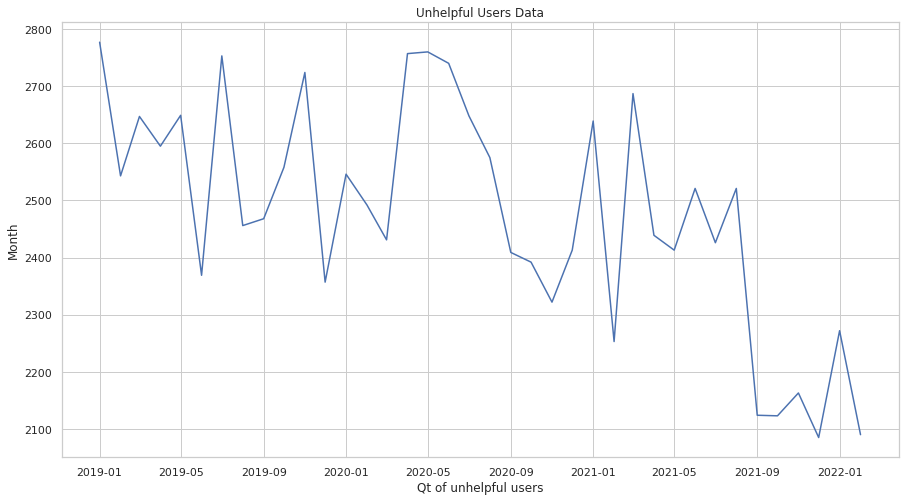

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "creation_month", y = "unhelpful_users", data=df6)
plt.xlabel("Qt of unhelpful users")
plt.ylabel("Month")
plt.title("Unhelpful Users Data")

Great news, the rate of Unhelpful users is decreasing.

# Question 7
What are the top few topics that are popular and trending but are not being answered?

For this question I have created an answer rate for each category (tag) that takes into account the number of questions asked in relation to the number of answers.

When this ratio is less than 1 it means that the number of answers does not cover the total number of questions (at all). The higher the ratio, the higher the response rate in relation to the questions.

Decreases in the ratio or popular topics with low ratios may indicate the need for engagement or promotion to improve the response rate, which would generate more satisfied users.

We select popular topics based on engagement measures (total comments, questions, favorites and replies).

In [ ]:
df7 = client.query('''

with tags as (SELECT tag, COUNT(*) total_questions, datas, sum(comment) comment, sum(answer) answer, sum(favorite) favorite, sum(comment + answer + favorite)+count(*) engagement
FROM (
  SELECT SPLIT(tags, '|') tags, date_trunc(creation_date, month) as datas, comment_count comment, answer_count answer, favorite_count favorite
  FROM `bigquery-public-data.stackoverflow.posts_questions` a
  WHERE EXTRACT(YEAR FROM creation_date)>=2019
), UNNEST(tags) tag
GROUP BY 1, 3
ORDER BY 2 DESC), toptags as (select tag, sum(total_questions) total from tags group by tag order by 2 desc limit 10)

SELECT t.*, IEEE_DIVIDE(answer, t.total_questions) as ratio FROM tags t
INNER JOIN toptags tt
on t.tag = tt.tag
where datas < '2022-01-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
order by tag asc

''').to_dataframe()

df7.head()

,tag,total_questions,datas,comment,answer,favorite,engagement,ratio
0,android,5129,2021-10-01 00:00:00+00:00,7692,3574,450,6774,0.696822
1,android,5478,2020-10-01 00:00:00+00:00,8696,5721,916,8571,1.044359
2,android,5240,2021-01-01 00:00:00+00:00,9819,5427,596,7523,1.035687
3,android,6360,2020-02-01 00:00:00+00:00,12554,7286,1219,11156,1.145597
4,android,7072,2019-05-01 00:00:00+00:00,14523,8367,1689,13278,1.183117


Text(0.5, 1.0, 'Categories (tags) popular and trending and you answers')

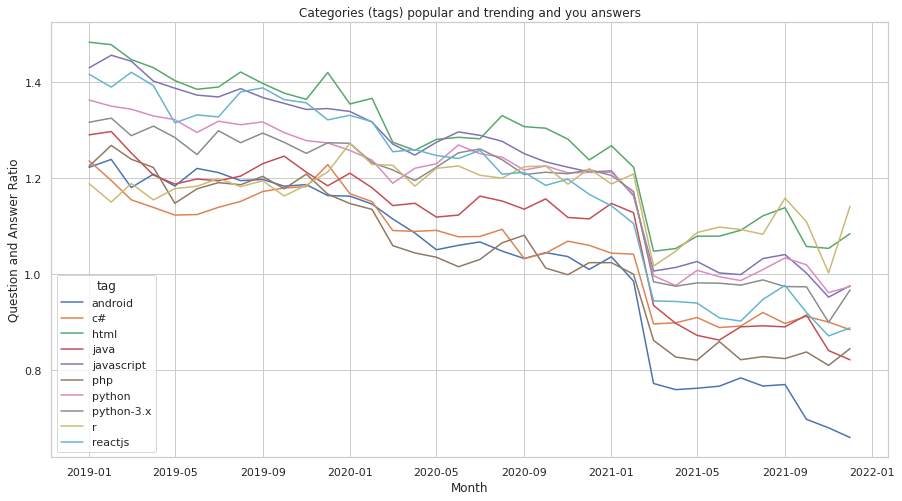

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "datas", y = "ratio", hue = 'tag', data=df7)
plt.xlabel("Month")
plt.ylabel("Question and Answer Ratio")
plt.title("Categories (tags) popular and trending and you answers")